Modern computer networks generate extremely large volumes of traffic, making it difficult to manually identify malicious activity in real time. Cyberattacks such as denial-of-service (DoS), port scanning, brute-force attacks, and infiltration attempts can disrupt services, compromise sensitive data, and result in significant financial and operational losses. As a result, automated and data-driven intrusion detection systems have become essential for modern cybersecurity.

This capstone project develops a complete machine-learning-based Network Intrusion Detection System (NIDS) that classifies network traffic as either benign or malicious using structured network flow data. The project is built using the CICIDS-2017 dataset, a widely used real-world benchmark that captures both normal traffic and multiple categories of network attacks.

The project follows an end-to-end data science workflow, starting from raw data ingestion and preprocessing, through feature engineering, model training, validation, and final evaluation. Three supervised machine-learning models are implemented and compared:

Logistic Regression as a baseline linear classification model

Decision Tree for interpretable, rule-based classification

Random Forest as an ensemble model for improved generalization and robustness

To ensure reliable and unbiased performance estimates, the models are evaluated using cross-validation and hyperparameter tuning, along with clearly defined evaluation metrics. Visualizations are used throughout the analysis to explore class distributions, feature behavior, and model performance, making the results interpretable and transparent.

Key outcomes of this capstone include:

A clean and well-structured data preprocessing pipeline

Feature engineering to improve model performance and stability

A comparative evaluation of multiple classification models

Clear interpretation of model results using appropriate metrics and visualizations

Actionable findings and recommendations for deploying ML-based intrusion detection systems

Overall, this project demonstrates how classical machine-learning techniques can be effectively applied to a real-world cybersecurity problem, delivering accurate, interpretable, and scalable solutions that support practical intrusion detection in modern network environments.

## 1. Data Loading and Environment Setup

The analysis begins by configuring the Python environment and loading the network intrusion dataset from cloud storage.

The dataset consists of multiple CSV files representing network traffic collected across different days and attack scenarios. These files are combined into a single dataframe to enable unified analysis.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [ ]:
DATASET_PATH = r"/content/drive/MyDrive/Berk_CapStone/dataset"
print("Loading dataset files...")

all_files = sorted(glob.glob(os.path.join(DATASET_PATH, "*.csv")))
print("Found files:", len(all_files))

if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")

def read_one_csv(path, sample_frac=None):
    df = pd.read_csv(path, encoding="cp1252", low_memory=False)
    df.columns = df.columns.str.strip()  # keep original but trimmed
    if sample_frac is not None and 0 < sample_frac < 1:
        df = df.sample(frac=sample_frac, random_state=42)
    return df

df_list = []
for f in all_files:
    print("Reading:", os.path.basename(f))
    try:
        # If Colab memory is tight, set sample_frac=0.2 (20%) temporarily
        df_list.append(read_one_csv(f, sample_frac=None))
    except Exception as e:
        print("Error:", f, e)

full_df = pd.concat(df_list, ignore_index=True)
print("Full dataset shape:", full_df.shape)
full_df.head()


Loading dataset files...
Found files: 7
Reading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: Monday-WorkingHours.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: Tuesday-WorkingHours.pcap_ISCX.csv
Reading: Wednesday-workingHours.pcap_ISCX.csv
Full dataset shape: (2830743, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443.0,192.168.10.5,54865.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80.0,192.168.10.5,55054.0,6.0,7/7/2017 3:30,109.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80.0,192.168.10.5,55055.0,6.0,7/7/2017 3:30,52.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443.0,192.168.10.16,46236.0,6.0,7/7/2017 3:30,34.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443.0,192.168.10.5,54863.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## 2. Column Name Standardization

Raw network datasets often contain inconsistent or poorly formatted column names.  
To improve readability and reduce the risk of coding errors, all column names are standardized by:

- Removing extra whitespace  
- Converting text to lowercase  
- Replacing spaces and special characters with underscores  

This step ensures consistency across the entire analysis and modeling pipeline.


In [ ]:
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(" ", "_")
          .str.replace("/", "_per_", regex=False)
          .str.replace("-", "_", regex=False)
    )
    return df

df = clean_columns(full_df)
print("Example columns:", df.columns[:15].tolist())


Example columns: ['flow_id', 'source_ip', 'source_port', 'destination_ip', 'destination_port', 'protocol', 'timestamp', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean']


## 3. Initial Dataset Inspection

After loading and standardizing the data, an initial inspection is performed to understand:

- The size of the dataset (rows and columns)
- The distribution of attack labels
- The types of features present (numeric vs categorical)
- The temporal range of the data

This step helps identify class imbalance, data type issues, and potential preprocessing requirements.


In [ ]:
print("Rows, Columns:", df.shape)
print("Label values:", df["label"].value_counts().head(15))
print("\nData types (top):")
print(df.dtypes.value_counts())

# Timestamp existence check
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    print("Timestamp range:", df["timestamp"].min(), "→", df["timestamp"].max())


Rows, Columns: (2830743, 85)
Label values: label
BENIGN                        1984531
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Web Attack – Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Data types (top):
float64    80
object      5
Name: count, dtype: int64
Timestamp range: 2017-04-07 01:00:00 → 2017-07-07 12:59:00


## 4. Handling Invalid and Infinite Values

Network flow features may contain infinite or undefined values due to division-by-zero operations during feature calculation.

To ensure numerical stability:
- Infinite values are replaced with missing values (NaN)
- Missing value percentages are calculated for each feature

This allows for safe imputation in later steps.


In [ ]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Show missingness
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("Top missing columns (%):")
print(missing_pct.head(15))

Top missing columns (%):
timestamp                      28.915377
flow_bytes_per_s               10.289242
flow_packets_per_s             10.289242
source_ip                      10.195274
source_port                    10.195274
destination_port               10.195274
destination_ip                 10.195274
flow_duration                  10.195274
protocol                       10.195274
total_backward_packets         10.195274
total_length_of_fwd_packets    10.195274
total_length_of_bwd_packets    10.195274
total_fwd_packets              10.195274
fwd_packet_length_max          10.195274
fwd_packet_length_min          10.195274
dtype: float64


## 5. Missing Value Treatment

Different strategies are used to handle missing values based on feature type:

- **Numeric features** are filled using the median value to reduce sensitivity to outliers
- **Categorical features** are filled with the placeholder value `"unknown"`

After this step, the dataset contains no missing values and is suitable for modeling.


In [ ]:
# Drop columns with >50% missing (adjust threshold if needed)
threshold = 50
drop_cols = missing_pct[missing_pct > threshold].index.tolist()
print("Dropping cols >", threshold, "% missing:", drop_cols)

df.drop(columns=drop_cols, inplace=True)

Dropping cols > 50 % missing: []


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill remaining non-numeric NaNs with "unknown"
cat_cols = [c for c in df.columns if c not in num_cols]
df[cat_cols] = df[cat_cols].fillna("unknown")

print("Missing after fix:", df.isna().sum().sum())

Missing after fix: 0


## 6. Exploratory Data Analysis: Class Distribution

Understanding how traffic classes are distributed is critical for intrusion detection.

This analysis examines:
- The frequency of each attack type
- The dominance of benign traffic
- The degree of class imbalance

These insights guide decisions around resampling, label grouping, and evaluation metrics.


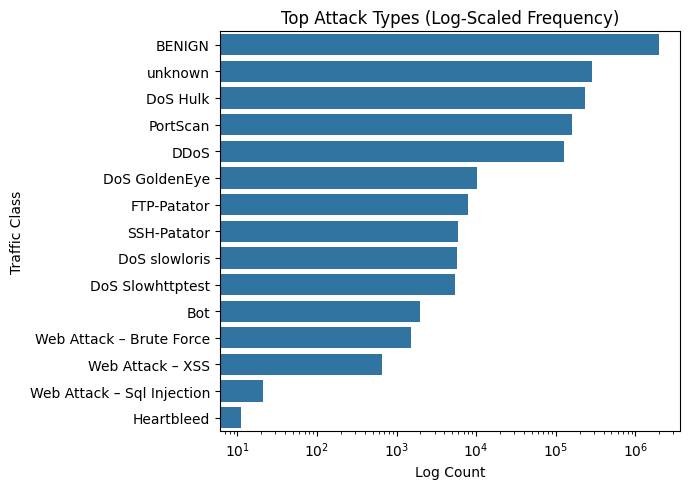

In [ ]:
# Aggregate label counts
label_counts = df["label"].value_counts().head(15)

plt.figure(figsize=(7,5))
sns.barplot(
    x=label_counts.values,
    y=label_counts.index,
    orient="h"
)

plt.xscale("log")  # <-- key improvement
plt.title("Top Attack Types (Log-Scaled Frequency)")
plt.xlabel("Log Count")
plt.ylabel("Traffic Class")
plt.tight_layout()
plt.show()


## 8. Class Balancing and Sampling

Some attack types appear far less frequently than others, which can negatively impact model performance.

To address this:
- Rare classes below a minimum threshold are removed
- The remaining classes are capped using stratified sampling

This creates a more balanced dataset while preserving representative attack patterns.


In [ ]:
df["label"] = df["label"].astype(str).str.strip()

min_samples = 5000
counts = df["label"].value_counts()
keep_classes = counts[counts >= min_samples].index

df_mc = df[df["label"].isin(keep_classes)].copy()
print("Classes kept:", df_mc["label"].nunique())
display(df_mc["label"].value_counts())


N_PER_CLASS = 10000

df_mc = (
    df_mc.groupby("label", group_keys=False)
         .apply(lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=42))
         .reset_index(drop=True)
)

print("After cap:", df_mc.shape)
display(df_mc["label"].value_counts())


Classes kept: 10


,count
label,
BENIGN,1984531
unknown,288602
DoS Hulk,231073
PortScan,158930
DDoS,128027
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796


/tmp/ipython-input-770253810.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), N_PER_CLASS), random_state=42))


After cap: (185423, 86)


,count
label,
BENIGN,30000
DDoS,30000
DoS Hulk,30000
PortScan,30000
unknown,30000
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796


## 9. Feature Engineering

Feature engineering is applied to extract additional information from raw network flow metrics and improve model generalization.

The following transformations are performed:

- **Ratio-based features** (e.g., forward vs backward packets/bytes) to capture directional traffic asymmetry commonly observed in attack behavior.
- **Log transformations** on heavy-tailed variables (e.g., flow duration, packet and byte rates) to stabilize distributions and reduce skew.
- **Removal of identifiers** such as IP addresses, flow IDs, and timestamps to prevent information leakage and reduce noise.
- **Numeric feature enforcement** to ensure model compatibility and consistent preprocessing across classifiers.

These transformations improve robustness while preserving meaningful traffic patterns.


In [ ]:
df_fe = df_mc.copy()

# Safe derived features (avoid divide by zero)
eps = 1e-9

if "total_fwd_packets" in df_fe.columns and "total_backward_packets" in df_fe.columns:
    df_fe["fwd_bwd_pkt_ratio"] = df_fe["total_fwd_packets"] / (df_fe["total_backward_packets"] + eps)

if "total_length_of_fwd_packets" in df_fe.columns and "total_length_of_bwd_packets" in df_fe.columns:
    df_fe["fwd_bwd_bytes_ratio"] = df_fe["total_length_of_fwd_packets"] / (df_fe["total_length_of_bwd_packets"] + eps)

if "flow_packets_per_s" in df_fe.columns and "flow_bytes_per_s" in df_fe.columns:
    df_fe["bytes_per_packet_est"] = df_fe["flow_bytes_per_s"] / (df_fe["flow_packets_per_s"] + eps)

# Log transform for heavy-tailed features (common in network flow)
for col in ["flow_duration", "flow_bytes_per_s", "flow_packets_per_s"]:
    if col in df_fe.columns:
        df_fe[f"log1p_{col}"] = np.log1p(df_fe[col].clip(lower=0))


In [ ]:
drop_cols = ["flow_id", "source_ip", "destination_ip", "timestamp", "label"]
X = df_fe.drop(columns=[c for c in drop_cols if c in df_fe.columns], errors="ignore")

# Keep numeric features only (stable for all models)
X = X.select_dtypes(include=[np.number])

y = df_fe["label"]

print("X shape:", X.shape, "| classes:", y.nunique())


X shape: (185423, 87) | classes: 10


## 10. Dataset Preparation for Modeling

After feature engineering, the dataset is prepared for machine learning by:

- Separating predictors (X) from the target variable (y)
- Retaining only numeric features for stable preprocessing
- Preserving all major attack classes for multi-class classification

The resulting dataset serves as the input for baseline and tuned models.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [ ]:
numeric_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ],
    remainder="drop"
)


## 11. Baseline Model Comparison Using Cross-Validation

Three classification models are evaluated:

- Decision Tree
- Logistic Regression
- Random Forest

Stratified k-fold cross-validation is used to ensure class proportions are preserved across folds.

**Evaluation Metric:**  
The **weighted F1-score** is used as the primary metric to account for class imbalance while penalizing poor performance on minority attack classes.


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

cv_rows = []

for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_weighted")
    cv_rows.append({"Model": name, "CV F1 (weighted) mean": scores.mean(), "CV F1 (weighted) std": scores.std()})

cv_df = pd.DataFrame(cv_rows).sort_values("CV F1 (weighted) mean", ascending=False)
cv_df


,Model,CV F1 (weighted) mean,CV F1 (weighted) std
0,Decision Tree,0.999525,0.000110
2,Random Forest,0.999389,0.000109
1,Logistic Regression,0.998053,0.000323


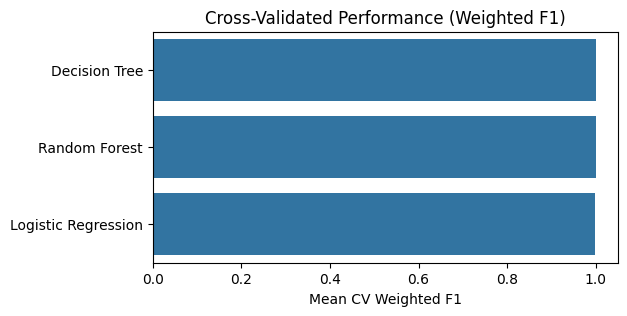

In [ ]:
plt.figure(figsize=(6,3))
sns.barplot(data=cv_df, x="CV F1 (weighted) mean", y="Model")
plt.title("Cross-Validated Performance (Weighted F1)")
plt.xlabel("Mean CV Weighted F1")
plt.ylabel("")
plt.show()


In [ ]:
dt_pipe = Pipeline(steps=[("preprocess", preprocess),
                         ("model", DecisionTreeClassifier(random_state=42))])

dt_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10, 20],
    "model__min_samples_leaf": [1, 5, 10]
}

dt_search = GridSearchCV(dt_pipe, dt_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
dt_search.fit(X_train, y_train)
dt_search.best_params_, dt_search.best_score_


({'model__max_depth': None,
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 2},
 np.float64(0.999525376714945))

In [ ]:
lr_pipe = Pipeline(steps=[("preprocess", preprocess),
                         ("model", LogisticRegression(max_iter=3000, n_jobs=-1))])

lr_grid = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

lr_search = GridSearchCV(lr_pipe, lr_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
lr_search.fit(X_train, y_train)
lr_search.best_params_, lr_search.best_score_


({'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'},
 np.float64(0.9982681288743283))

In [ ]:
rf_pipe = Pipeline(steps=[("preprocess", preprocess),
                         ("model", RandomForestClassifier(random_state=42, n_jobs=-1))])

rf_grid_fast = {
    "model__n_estimators": [150],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5],
    "model__class_weight": ["balanced_subsample"]
}

rf_search = GridSearchCV(rf_pipe, rf_grid, cv=cv, scoring="f1_weighted", n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_search.best_params_, rf_search.best_score_


({'model__class_weight': 'balanced_subsample',
  'model__max_depth': 20,
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 10,
  'model__n_estimators': 200},
 np.float64(0.9993886766271836))

In [ ]:
tuned_results = pd.DataFrame([
    {"Model": "Decision Tree (tuned)", "Best CV F1 (weighted)": dt_search.best_score_},
    {"Model": "Logistic Regression (tuned)", "Best CV F1 (weighted)": lr_search.best_score_},
    {"Model": "Random Forest (tuned)", "Best CV F1 (weighted)": rf_search.best_score_},
]).sort_values("Best CV F1 (weighted)", ascending=False)

tuned_results


,Model,Best CV F1 (weighted)
0,Decision Tree (tuned),0.999525
2,Random Forest (tuned),0.999389
1,Logistic Regression (tuned),0.998268


In [ ]:
best_model = rf_search.best_estimator_  # change if another wins
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))


                  precision    recall  f1-score   support

          BENIGN     0.9993    1.0000    0.9997      7500
            DDoS     1.0000    1.0000    1.0000      7500
   DoS GoldenEye     0.9984    0.9996    0.9990      2573
        DoS Hulk     0.9989    0.9993    0.9991      7500
DoS Slowhttptest     0.9985    0.9964    0.9975      1375
   DoS slowloris     0.9972    0.9972    0.9972      1449
     FTP-Patator     1.0000    1.0000    1.0000      1985
        PortScan     1.0000    0.9989    0.9995      7500
     SSH-Patator     1.0000    1.0000    1.0000      1474
         unknown     1.0000    1.0000    1.0000      7500

        accuracy                         0.9995     46356
       macro avg     0.9992    0.9991    0.9992     46356
    weighted avg     0.9995    0.9995    0.9995     46356



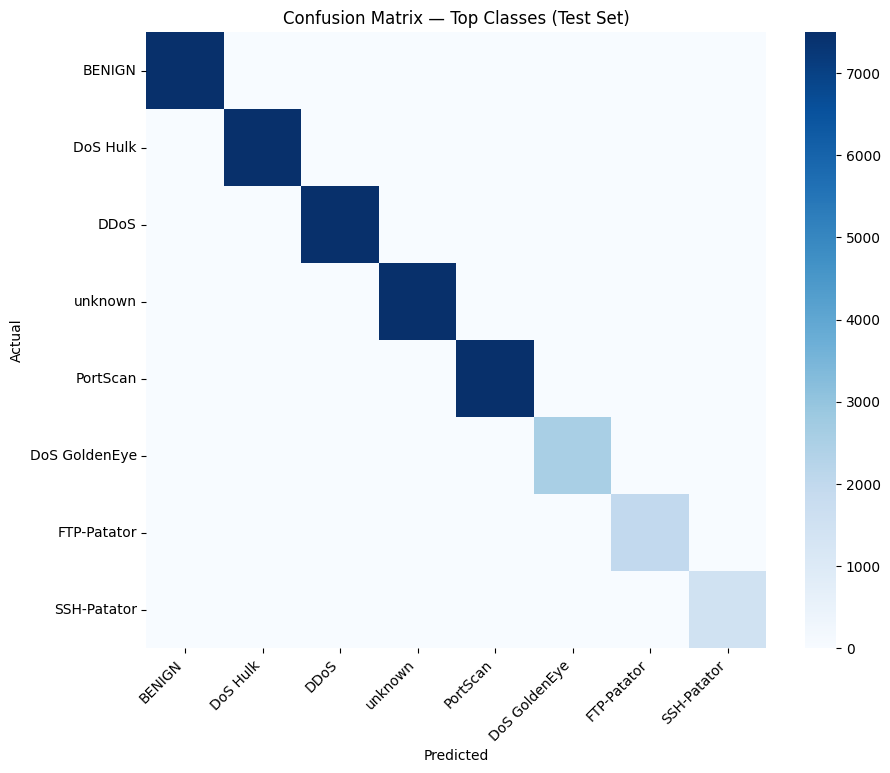

In [ ]:
top_classes = y_test.value_counts().index[:8].tolist()

mask = y_test.isin(top_classes)
cm = confusion_matrix(y_test[mask], y_pred[mask], labels=top_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", xticklabels=top_classes, yticklabels=top_classes)
plt.title("Confusion Matrix — Top Classes (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


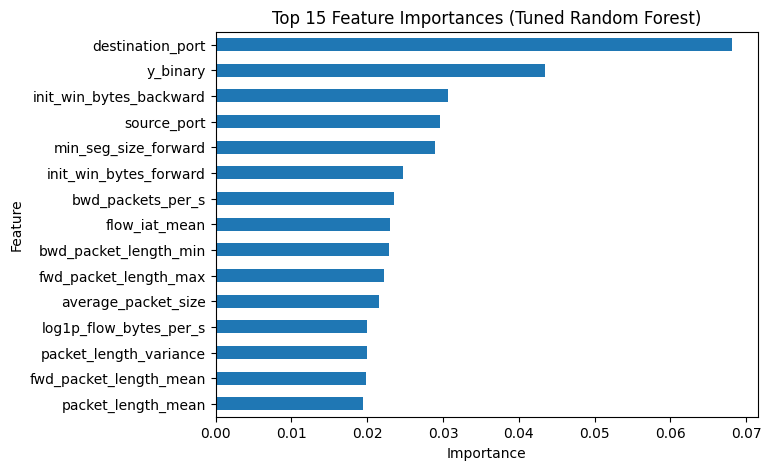

In [ ]:
# Only works if best_model is RF
if hasattr(best_model.named_steps["model"], "feature_importances_"):
    importances = best_model.named_steps["model"].feature_importances_
    feat_names = X.columns
    imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)

    plt.figure(figsize=(7,5))
    imp.sort_values().plot(kind="barh")
    plt.title("Top 15 Feature Importances (Tuned Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    imp
